In [1]:
%load_ext autoreload
%autoreload 2
import torch
from modules.competition_dataset import EEGDataset, LABELS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.covariance import EmpiricalCovariance
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_classif
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
data_path = './data/mtcaic3'
lda_model_path = './checkpoints/mi/models/lda_mi.pkl'

# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seeds(42)

In [3]:
window_length = 256
stride = window_length // 3
batch_size = 64

In [6]:
eeg_channels = [
    "C3", # 2296.15
    "PZ", # 1744.43
    "C4", # 1556.46
    # "OZ" # 444.98
    # "PO7" # 381.63
    # "PO8" # 275.78
    # "CZ" # 200.43
    # "FZ" # 111.51
]


dataset_train = EEGDataset(
    data_path,
    window_length=window_length,
    stride=stride,
    task="mi",
    split="train",
    data_fraction=1.0,
    hardcoded_mean=False,
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    task='mi',
    split='validation',
    read_labels=True,
    hardcoded_mean=False,
    eeg_channels=eeg_channels,
)

dataset_test = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    task='mi',
    split='test',
    read_labels=False,
    hardcoded_mean=False,
    eeg_channels=eeg_channels,
)

task: mi, split: train, domain: time, data_fraction: 1.0
skipped: 0/2400
not normalizing...
task: mi, split: validation, domain: time, data_fraction: 1.0
skipped: 0/50
not normalizing...
task: mi, split: test, domain: time, data_fraction: 1.0
skipped: 0/50
not normalizing...


In [7]:
all_data = torch.cat([torch.stack([x for x,_ in ds]) for ds in (dataset_train, dataset_val, dataset_test)])
X_val_train = torch.cat([torch.stack([x for x,_ in ds]) for ds in (dataset_train, dataset_val)])
y_val_train = torch.cat([torch.stack([y for _,y in ds]) for ds in (dataset_train, dataset_val)])

mean = all_data.mean((0, 2))
std = all_data.std((0, 2))

X_val_train = (X_val_train - mean[None, :, None]) / std[None, :, None]

mean, std

(tensor([-1.8794, -1.6775, -5.1054]),
 tensor([1745.9202, 2063.0957, 2298.0815]))

In [6]:
# F score to reveal most relevant features
num_samples, num_channels, time_points = X_val_train.shape
original_channel_names = ["FZ","C3","CZ","C4","PZ","PO7","OZ","PO8"]

print(f"Data shape for selection: {X_val_train.shape}, Labels shape: {y_val_train.shape}")

channel_f_scores = []

print("\nCalculating F-scores for each channel...")
for i in range(num_channels):
    channel_data = X_val_train[:, i, :]
    
    f_scores_per_timepoint, _ = f_classif(channel_data, y_val_train)
    
    aggregated_f_score = np.sum(f_scores_per_timepoint)
    channel_f_scores.append(aggregated_f_score)

channel_scores_dict = {original_channel_names[i]: channel_f_scores[i] for i in range(num_channels)}

print("\n--- F-scores for each channel (higher score indicates more informativeness) ---")
sorted_channels = sorted(channel_scores_dict.items(), key=lambda item: item[1], reverse=True)
for channel, score in sorted_channels:
    print(f"  {channel}: {score:.2f}")

top_3_channels = [channel for channel, score in sorted_channels[:3]]
print(f"\n--- Recommended Top 3 Channels based on F-score: {top_3_channels} ---")

Data shape for selection: torch.Size([42984, 8, 256]), Labels shape: torch.Size([42984])

Calculating F-scores for each channel...

--- F-scores for each channel (higher score indicates more informativeness) ---
  C3: 2296.15
  PZ: 1744.43
  C4: 1556.46
  OZ: 444.98
  PO7: 381.63
  PO8: 275.78
  CZ: 200.43
  FZ: 111.51

--- Recommended Top 3 Channels based on F-score: ['C3', 'PZ', 'C4'] ---


Data prepared for t-SNE with shape: (5000, 768)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 3.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.328693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.697510
[t-SNE] KL divergence after 1000 iterations: 0.562599
t-SNE completed.


C:\Users\ahmad\AppData\Local\Temp\ipykernel_23292\1148589758.py:27: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


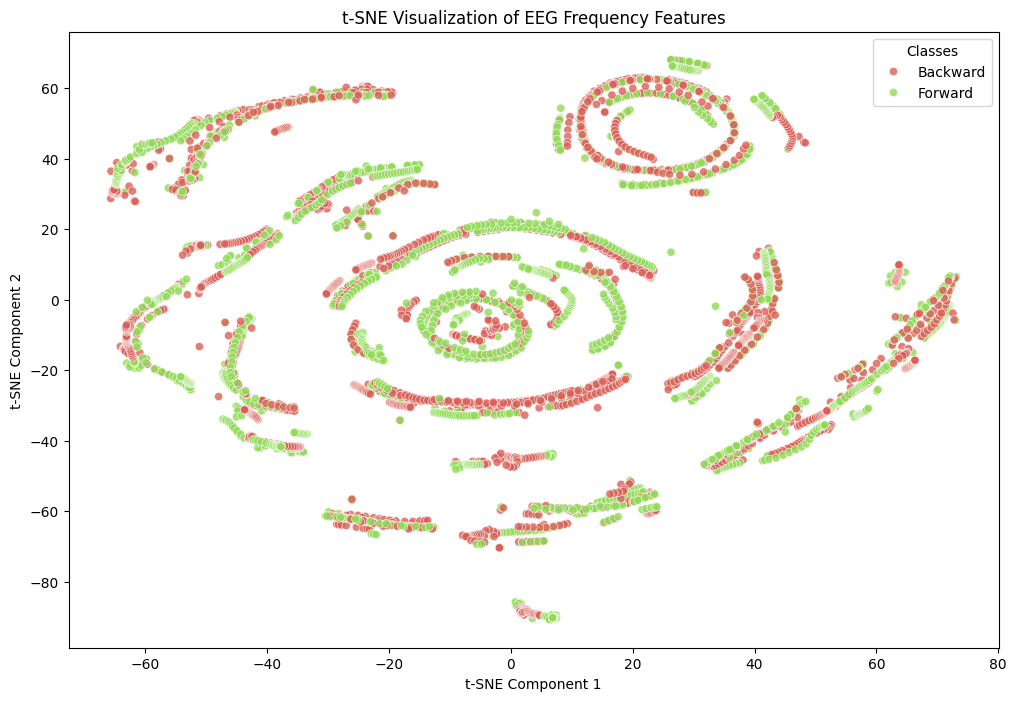

Trustworthiness: 0.9978080368589743
Silhouette (high-D): 0.0005377089255489409
Silhouette (2-D): 0.0011009856825694442


In [8]:
# T-SNE to reveal how separatable the data is
num_batches_for_tsne = 5

all_features = X_val_train[:5000].numpy()
all_labels = y_val_train[:5000].numpy()

n_samples = all_features.shape[0]
flattened_features = all_features.reshape(n_samples, -1) # n_samples x n_channels * n_freq_bins

print(f"Data prepared for t-SNE with shape: {flattened_features.shape}")

tsne = TSNE(
    n_components=2,      # We want a 2D plot
    verbose=1,           # Print progress
    perplexity=30,       # A good default value, relates to # of nearest neighbors
    learning_rate='auto',
    init='pca'
)
tsne_results = tsne.fit_transform(flattened_features)

print("t-SNE completed.")

df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
df_tsne['label'] = [LABELS[l] for l in all_labels] 

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4), # Use 4 distinct colors for the 4 classes
    data=df_tsne,
    legend="full",
    alpha=0.8 # Set transparency of points
)

plt.title('t-SNE Visualization of EEG Frequency Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


X_high = flattened_features            # n_samples × (n_channels*n_freq_bins)
X_low  = tsne_results                  # n_samples × 2
y      = all_labels

# how well local structure is preserved
print("Trustworthiness:", trustworthiness(X_high, X_low, n_neighbors=5))

# cluster separability in the original space
print("Silhouette (high-D):", silhouette_score(X_high, y))

# cluster separability in the embedding
print("Silhouette (2-D):", silhouette_score(X_low, y))

train: 42127, val: 857, test: 857


Text(0, 0.5, 'Count')

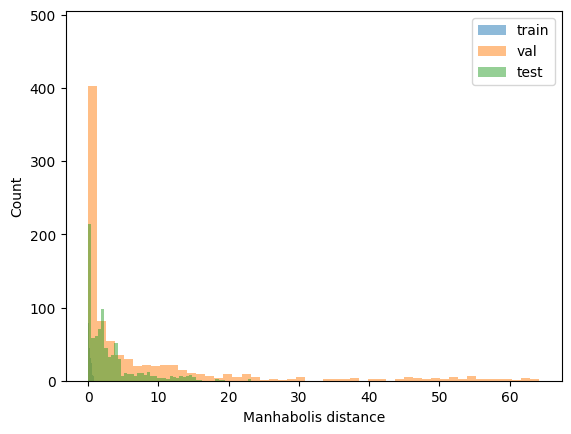

In [9]:
# Mahalopis
print(f"train: {len(dataset_train.data)}, val: {len(dataset_val.data)}, test: {len(dataset_val.data)}")
ec = EmpiricalCovariance().fit(dataset_train.data.mean(axis=2))


d_train = ec.mahalanobis(dataset_train.data[:2000, :].mean(axis=2))
d_val = ec.mahalanobis(dataset_val.data.mean(axis=2))
d_test = ec.mahalanobis(dataset_test.data.mean(axis=2))

plt.hist(d_train, bins=50, alpha=0.5, label="train")
plt.hist(d_val, bins=50, alpha=0.5, label="val")
plt.hist(d_test, bins=50, alpha=0.5, label="test")

plt.legend()
plt.xlabel('Manhabolis distance')
plt.ylabel('Count')